In [1]:
!pip install scrapy crochet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import scrapy
from scrapy.loader import ItemLoader
from scrapy.crawler import CrawlerRunner
from dateutil.parser import parse

from datetime import datetime

import pandas as pd

[Scrapy](https://docs.scrapy.org/en/latest/) - фреймворк для парсинга сайтов. 

Более мощный и функциональный инструмент, чем связка requests + bs4

### Попробуем в этот раз спарсить vc.ru

Дл начала познакомимся с понятием sitemap. 

Sitemap - это XML-файл с информацией для поисковых систем (таких как Google, Яндекс, Bing, Поиск@Mail.Ru) о страницах веб-сайта, которые подлежат индексации. 

У vc.ru sitemap можно найти по ссылке https://vc.ru/sitemap.xml 

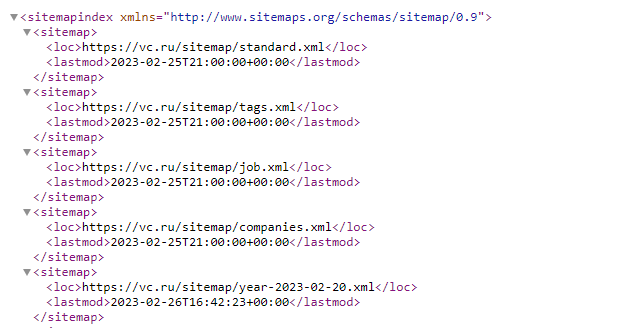

В целом можно, например, используя этот sitemap как отправную точку, спарсить 100 статей vc.ru, скажем, начиная с 2022-02-01

Будем сохранять текст статьи, название и дату публикации. Для этого определим класс, в который будем загружать полученные данные

In [3]:
class Article(scrapy.Item):
    text = scrapy.Field()
    title = scrapy.Field()
    publication_date = scrapy.Field()

Для получения отдельных элементов на странице, кроме различных html и css-селекторов, как мы это делали в bs4, используя классы html-элементов, можно использовать xpath-селекторы.

Xpath — это язык запросов к элементам xml или xhtml документа. Подробно об xpath-запросах можно почитать в:
- [XPath примеры - шпаргалка для разбора страниц](https://xn--80afqpaigicolm.xn--p1ai/theory/xpath-example/)
- [Примеры xpath-запросов к html](https://habr.com/ru/post/114772/)
- [Scrapy Selectors](https://docs.scrapy.org/en/latest/topics/selectors.html)


In [4]:
class Config:
    """Класс для конфигурации xpath-запросов
    text_xpath - xpath элемента с основным текстом статьи;
    title_path - xpath элемента с основным наименованием статьи;
    publication_date_path - xpath элемента с датой публикации.
    """
    def __init__(self, text_xpath, title_path, publication_date_path):
        self.text_xpath = text_xpath
        self.title_path = title_path
        self.publication_date_path = publication_date_path

In [5]:
class VcSpider(scrapy.Spider):
    name = "VcSpider"

    # С этой ссылки начнется обход
    start_urls = ['https://vc.ru/sitemap.xml']

    # Эти ссылки пропустим во время обхода
    skip_urls = [
        'https://vc.ru/sitemap/tags.xml',
        'https://vc.ru/sitemap/job.xml',
        'https://vc.ru/sitemap/companies.xml',
    ]

    # Пропишем сохранение в csv
    custom_settings = {
        "FEEDS": {
            "items.csv": {
                'format': 'csv',
                'overwrite': True
            },
        },
    }

    # Зададим xpath-запросы к тексту, названию и дате статьи в конфиге
    config = Config(
        text_xpath='//div[contains(@class, "content--full")]//p/text()',
        title_path='normalize-space(//h1[contains(@class, "content-title")]//text())',
        publication_date_path='//time[contains(@class, "time")]//@title'
    )

    # Начнем сохранять статьи с этой даты
    begin_from = '2023-02-01'

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cnt = 0      

    def parse(self, response):
        """Функция для парсинга ссылок первого уровня (в данном случае sitemap из start_urls).
        Args:
            response: ответ на запрос (request) к start_url.
        """
        body = response.body

        # Вытаскиваем ссылки и даты из sitemap по xpath
        sitemap_urls = scrapy.Selector(text=body).xpath("//loc/text()").getall()
        sitemap_dates = scrapy.Selector(text=body).xpath("//lastmod/text()").getall()

        for url, dt in zip(sitemap_urls, sitemap_dates):
            # Пропускаем ненужные ссылки
            if url in self.skip_urls:
                continue
            dt = parse(dt)

            if dt and dt.date() >= parse(VcSpider.begin_from).date():
                # Если на первом уровне все ок, идем дальше и парсим ссылку второго уровня - новый request
                yield scrapy.Request(url=url, callback=self.parse_sitemap_url) 

    def parse_sitemap_url(self, response):
        """Функция для парсинга ссылок второго уровня (по запросу из parse).
        В данном случае ссылки вида https://vc.ru/sitemap/year-2020-02-10.xml
        Args:
            response: ответ на запрос (request) к sitemap-url.
        """
        body = response.body
        urls = scrapy.Selector(text=body).xpath("//loc/text()").getall()
        sitemap_dates = scrapy.Selector(text=body).xpath("//lastmod/text()").getall()

        for url, dt in zip(urls, sitemap_dates):
            dt = parse(dt)

            # Если уже сохранили 100 статей - заканчиваем парсинг
            if self.cnt >= 100:
              raise scrapy.exceptions.CloseSpider('Limit exceeded')

            if dt and dt.date() >= parse(VcSpider.begin_from).date():
                self.cnt += 1
                # Если и тут все ок, финально парсим статью
                yield scrapy.Request(url=url, callback=self.parse_page)

    def parse_page(self, response):
        """Функция для парсинга отдельной html страницы.
        Функция является генератором и возвращает отдельный элемент с данными страницы.
        :param response: ответ на запрос (request) к url конкретной статьи.
        """
        # Вытаскиваем текст, название и дату
        pub_date_list = response.xpath(self.config.publication_date_path).extract()
        text = ' '.join(response.xpath(self.config.text_xpath).extract())
        title = response.xpath(self.config.title_path).extract()
        publication_date = ' '.join(pub_date_list[0].split()[:2]) if pub_date_list else ''

        loader = ItemLoader(item=Article(), response=response)
        loader.add_value("title", title)
        loader.add_value("text", text)
        loader.add_value("publication_date", publication_date)
        yield loader.load_item()

### Запуск с crochet

Вообще говоря, scrapy скорее предназначен для создания парсеров в виде полноценных python-проектов, разбитых на отдельные модули и запускающиеся через shell. Spider для vc.ru реализован в jupyter notebook чисто для наглядности, поэтому с обычным запуском может возникнуть проблема - ошибка `ReactorNotRestartable`

Для ее решения можно либо перезапускать среду каждый раз, либо использовать [crochet](https://github.com/itamarst/crochet), раз уж мы вообще запускаем scrapy в колабе.


PS. Пример того, как могут выглядеть scrapy-спайдеры в виде python-скриптов можно посмотреть в проекте [newsviz](https://github.com/newsviz/Spiders)

In [6]:
from crochet import setup, wait_for
setup()

In [7]:
@wait_for(20)
def run_spider():
    crawler = CrawlerRunner()
    return crawler.crawl(VcSpider)

In [8]:
run_spider()


It is also the default value. In other words, it is normal to get this warning if you have not defined a value for the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting. This is so for backward compatibility reasons, but it will change in a future version of Scrapy.

See the documentation of the 'REQUEST_FINGERPRINTER_IMPLEMENTATION' setting for information on how to handle this deprecation.


In [9]:
pd.set_option('display.max_colwidth', 400)
data = pd.read_csv('items.csv')
data.head()

,publication_date,text,title
0,13.02.2023 22:50:10,"Добро пожаловать в библиотеку генеративного искусственного интеллекта. Изучите более 500 нейросетей для создания избражений и др. контента. Список самых популярных нейросетей Нейросеть с открытым исходным кодом. Включает в себя такие инструменты как out painting, in painting, матрицу подсказок, масштабирование, текстовую инверсию, генерацию пакетов, рандомизаторы. Discord-бот для создания изоб...",20 лучших нейросетей для создания контента в 2023 году
1,13.02.2023 22:19:01,С 13 по 19 февраля «Москвариум» дарит возможность устроить для своей второй половинки оригинальные свидания. В течение недели под названием «Океан любви» влюблённые получат на покупку двух билетов в Аквариум и множество идей для романтических свиданий. Близится праздник всех влюбленных – День Святого Валентина. В этот день каждому хочется не просто вручить близкому человеку традиционную откр...,«Москвариум» дарит возможность устроить для своей второй половинки оригинальные свидания
2,13.02.2023 22:54:25,"Привет всем! Сегодня рассмотрим курсы программирования в Москве, которые можно пройти абсолютно без нервов. Вы получите полную информацию о обучении и выдаче сертификата. 20 Лучших платформ с бесплатными/платными курсами программирования в Москве в 2023 году : русский : Москва и область : популярные языки — JS, Java, Kotlin, IOS, веб разработка и др. : 5/5 : бесплатные вебинары и интенсивы, ку...","Где обучиться программировать с нуля на Python, Javascript, Ruby и др. языках в 2023 году с выдачей сертификата или нет"
3,13.02.2023 23:20:03,"Доверители, обращаясь с запросом о взыскании алиментов, часто бывают удивлены тому, что чтобы взыскать алименты не обязательно расторгать брак с матерью/отцом ребенка. Нахождение в браке никаким образом не препятствует взысканию алиментов и, более того, не влияет на размер присуждаемых выплат. В случае, если родители не предоставляют содержание своим несовершеннолетним детям, средства на соде...",Возможно ли взыскать алименты на ребенка в браке?
4,13.02.2023 22:55:00,"Получить до 10 уроков в подарок при покупке пакета занятий: Промокод SPRING действует на обычные пакеты уроков, подписки, калькуляторные пакеты, короткие уроки и на тариф «Премиум». Подробнее об онлайн-школе Skyeng:",Изучайте английский выгодно в Skyeng: до 10 уроков в подарок по промокоду — SPRING


В целом, конечно, Scrapy сильно сложнее и мощнее, чем представлен в этом примере, поэтому стоит ознакомиться с его документацией, как минимум с некоторыми [общепринятыми практиками](https://docs.scrapy.org/en/latest/topics/practices.html)